Cài đặt các thư viện cần thiết

In [31]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

Tiếp theo là đọc dữ liệu: Sau khi đã giải nén file dữ liệu, chúng ta sẽ bắt đầu với việc đọc danh sách ảnh

link: "../image_retrieval_dataset"

In [32]:
dataset_dir = '../image_retrieval_dataset/images_mr'
image_filenames = os.listdir(dataset_dir)
src_images = []
for filename in image_filenames:
    filepath = os.path.join(
        dataset_dir, filename
    )
    image = cv2.imread(filepath)
    image = cv2.cvtColor(
        image, cv2.COLOR_BGR2RGB
    )
    src_images.append(image)

print(f"✅ Đã đọc {len(src_images)} ảnh từ {dataset_dir}")

✅ Đã đọc 9908 ảnh từ ../image_retrieval_dataset/images_mr


### Lưu src_images để tái sử dụng
Lưu danh sách ảnh đã đọc vào file để tránh phải đọc lại nhiều lần

In [12]:
# Lưu src_images dưới dạng NumPy array (.npy)
# Resize tất cả ảnh về cùng kích thước trước khi lưu
resized_images = [cv2.resize(img, (64, 64)) for img in src_images]
src_images_array = np.array(resized_images)
np.save('src_images.npy', src_images_array)

print(f"✅ Đã lưu {len(src_images)} ảnh vào file 'src_images.npy'")
print(f"📦 Kích thước: {src_images_array.shape}")

✅ Đã lưu 9908 ảnh vào file 'src_images.npy'
📦 Kích thước: (9908, 64, 64, 3)


### Đọc lại src_images từ file (khi cần)
Khi restart kernel hoặc chạy lại notebook, có thể load nhanh từ file thay vì đọc lại từ ảnh gốc

In [13]:
# Đọc lại src_images từ file .npy
src_images_array = np.load('src_images.npy')
# Chuyển về list nếu cần làm việc với từng ảnh riêng lẻ
src_images = [src_images_array[i] for i in range(len(src_images_array))]

print(f"✅ Đã load {len(src_images)} ảnh từ file 'src_images.npy'")
print(f"📦 Kích thước mỗi ảnh: {src_images[0].shape}")

✅ Đã load 9908 ảnh từ file 'src_images.npy'
📦 Kích thước mỗi ảnh: (64, 64, 3)


Trong đó:
• Dòng 1: Khai báo đường dẫn đến thư mục chứa ảnh.
• Dòng 2: Sử dụng hàm os.listdir() để lấy danh sách các tên file ảnh.
• Dòng 3: Khai báo danh sách rỗng dùng để chứa ảnh đã đọc.
• Dòng 4: Duyệt qua từng tên ảnh.
• Dòng 5, 6, 7: Khai báo đường dẫn của ảnh đang xét bằng cách nối thư mục chứa ảnh và tên ảnh sử dụng hàm os.path.join().
• Dòng 8, 9, 10, 11: Đọc ảnh và đổi kênh màu của ảnh từ BGR (mặc định của OpenCV)
sang RGB.
• Dòng 12: Thêm ảnh vừa đọc được vào danh sách khai báo ở dòng 3

Tiền xử lý dữ liệu ảnh: Để cho việc tính toán truy vấn ảnh nhanh và chính xác hơn, chúng
ta sẽ áp dụng một số phương pháp tiền xử lý ảnh (bước tiền xử lý dữ liệu thường được áp dụng
trong hầu hết các bài toán liên quan đến Machine Learning). Các kỹ thuật tiền xử lý ảnh được
áp dụng trong chương trình bao gồm:

In [35]:
# Resizing: Thay đổi kích thước của ảnh về kích thước chung. Mặc định là (64, 64)
def image_resize (images , target_size =(64 , 64) ) :
    resized_image = cv2.resize (images , target_size )
    return resized_image

Normalizing: Chuẩn hóa giá trị trong ảnh sử dụng Z-score Normalization. Từ một ảnh X
và danh sách ảnh I, công thức chuẩn hóa ảnh được diễn đạt như sau:

Xnormalized = ( X - mean(I)) / std(I)


In [36]:
def calculate_mean_std ( images ) :
    mean = np.mean (images , axis =(0 , 1, 2) )
    std = np.std(images , axis =(0 , 1 , 2) )
    return mean , std

In [37]:
# Sau đó, ta chỉ việc triển khai lại công thức thành một hàm normalize:
def image_std_normalize (images , mean , std) :
    normalized_image = ( images - mean ) / std
    return normalized_image

Flattening: Để có thể dễ dàng tính toán độ tương đồng giữa các cặp ảnh, ta sẽ chuyển ảnh
thành vector 1D bằng phép flatten. Ở đây, ta thiết kế một hàm có thể xử lý hai trường hợp
đầu vào: trường hợp chỉ có một ảnh và trường hợp có danh sách các ảnh.

In [38]:
def image_flatten (images , is_batch = False ) :
    if is_batch :
        flattened_image = images . reshape ( images . shape [0] , -1)
    else :
        flattened_image = images . reshape ( -1)
    return flattened_image

In [39]:
# Hàm tiền xử lí ảnh cho danh sách ảnh
def preprocess_batches ( images ) :
    resized_images = [
        image_resize ( image ) for image in images
    ]
    images_arr = np. array ( resized_images )
    mean , std = calculate_mean_std ( images_arr )
    normalized_images = image_std_normalize (
        images_arr ,
        mean , std
    )
    flattened_images = image_flatten (
        normalized_images ,
        is_batch = True
    )

    return flattened_images , mean , std

In [40]:
# Tiền xử lý toàn bộ src_images
preprocessed_src_images, mean, std = preprocess_batches(src_images)
print(f"✅ Đã tiền xử lý {len(src_images)} ảnh")
print(f"📊 Shape: {preprocessed_src_images.shape}")

✅ Đã tiền xử lý 9908 ảnh
📊 Shape: (9908, 12288)


In [41]:
# Hàm tiền xử lí ảnh cho truy vấn
def preprocess_query(image, mean, std):
    resized_image = image_resize(image)
    normalized_image = image_std_normalize(resized_image, mean, std)
    flattened_image = image_flatten(normalized_image)
    return flattened_image

In [42]:
#Hàm tương đồng

# Hàm tính Mean Absolute Error (MAE)
def mean_absolute_error ( query_vector , src_vectors ) :
    abs_diff = np. abs( src_vectors - query_vector )
    mae = np. mean ( abs_diff , axis =1)

    return mae

# Hàm tính Mean Squared Error (MSE)
def mean_squared_error ( query_vector , src_vectors ) :
    squared_diff = ( src_vectors - query_vector ) ** 2
    mse = np. mean ( squared_diff , axis =1)

    return mse

# Hàm tính Cosine Similarity
def cosine_similarity ( query_vector , src_vectors ) :
    query_norm = np. linalg . norm ( query_vector )
    normalized_query = query_vector / query_norm
    src_norms = np. linalg . norm ( src_vectors , axis =1)
    normalized_src = src_vectors / src_norms [: , np. newaxis ]

    cosine_similarity = np.dot( normalized_src , normalized_query )

    return cosine_similarity

# Hàm tính Correlation Coefficient
def correlation_coefficient ( query_vector , src_vectors ) :
    return np. corrcoef ( query_vector , src_vectors ) [: -1 , -1]

In [43]:
# Ranking
def ranking ( preprocessed_query_image , preprocessed_src_images , top_k =10) :
    scores = cosine_similarity (
        preprocessed_query_image ,
        preprocessed_src_images
    )
    ranked_list = np. argsort ( scores ) [:: -1][: top_k ]
    scores = scores [ ranked_list ]

    return ranked_list , scores

Trong đó:
• Dòng 1: Khai báo hàm ranking() với 3 tham số đầu vào gồm: array ảnh truy vấn (query_image),
danh sách vector ảnh nguồn (src_images) và số lượng kết quả trả về (top_k).
• Dòng 2, 3, 4, 5: Thực hiện tính độ tương đồng giữa vector ảnh truy vấn so với các vector
ảnh nguồn. Ở đây ta dùng cosine_similarity(), các bạn có thể thay thế bằng những hàm tính
độ tương đồng khác.
• Dòng 6: Sắp xếp điểm tương đồng theo thứ tự giảm dần về mặt giá trị, biểu diễn kết quả
theo chỉ mục (arg), đồng thời chỉ lấy top_k kết quả.
• Dòng 7: Lấy điểm tương đồng ứng với top_k kết quả.
• Dòng 9: Trả về danh sách xếp hạng và điểm tương đồng

In [44]:
# QUERY - Lấy một ảnh bất kỳ từ dataset làm ảnh truy vấn
# Hoặc bạn có thể thay đổi đường dẫn đến ảnh của bạn
query_image_paths = [
    os.path.join(dataset_dir, image_filenames[0])  # Lấy ảnh đầu tiên làm query test
]
print(f"🔍 Query image: {query_image_paths[0]}")

🔍 Query image: ../image_retrieval_dataset/images_mr\0.jpg


Query Image


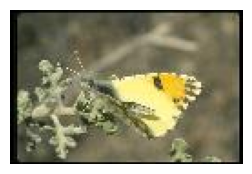

Top 10 results


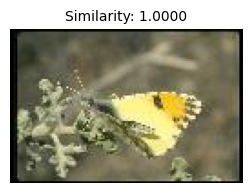

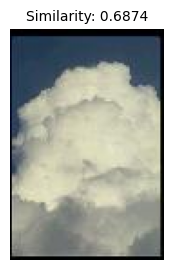

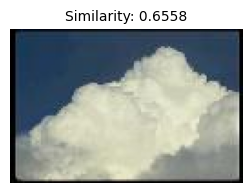

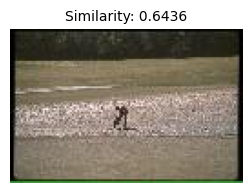

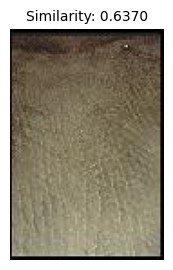

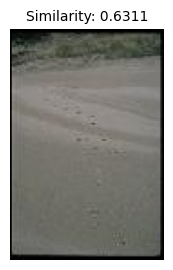

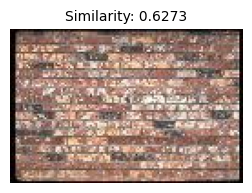

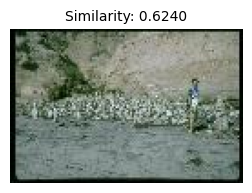

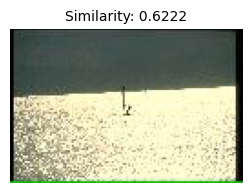

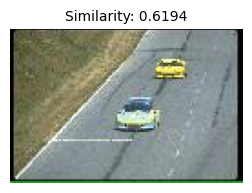

In [45]:
top_k = 10

for query_image_path in query_image_paths:
    # Đọc ảnh truy vấn
    query_image = cv2.imread(query_image_path, 1)
    
    if query_image is None:
        print(f"❌ Không thể đọc ảnh: {query_image_path}")
        continue
        
    query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
    
    # Tiền xử lý ảnh truy vấn
    preprocessed_query_image = preprocess_query(query_image, mean, std)
    
    # Tìm kiếm ảnh tương đồng
    ranked_list, scores = ranking(
        preprocessed_query_image,
        preprocessed_src_images,
        top_k
    )
    
    # Hiển thị ảnh truy vấn
    print('Query Image')
    plt.figure(figsize=(3, 3))
    plt.imshow(query_image)
    plt.axis('off')
    plt.show()
    
    # Hiển thị kết quả
    print(f'Top {top_k} results')
    for idx in range(len(ranked_list)):
        src_image_idx = ranked_list[idx]
        similarity_score = scores[idx]
        plt.figure(figsize=(3, 3))
        plt.imshow(src_images[src_image_idx])
        plt.title(f'Similarity: {similarity_score:.4f}', fontsize=10)
        plt.axis('off')
        plt.show()